# `CLOUD.jl` - 2D linear advection

In [3]:
using CLOUD
using OrdinaryDiffEq
using LinearAlgebra
using TimerOutputs
plots_path = "../../ResearchDocs/ICCFD2022/"
results_path = "../results/advection_collapsed_2D/";

┌ Info: Precompiling CLOUD [fb992021-99c7-4c2d-a14b-5e48ac4045b2]
└ @ Base loading.jl:1342


Define the physical problem

In [4]:
θ = π/4
a = sqrt(2)
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(cos(θ))))  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation((a*cos(θ),a*sin(θ)),λ=0.0);

Set up a collapsed DGSEM of degree `p` with `M` intervals in each direction

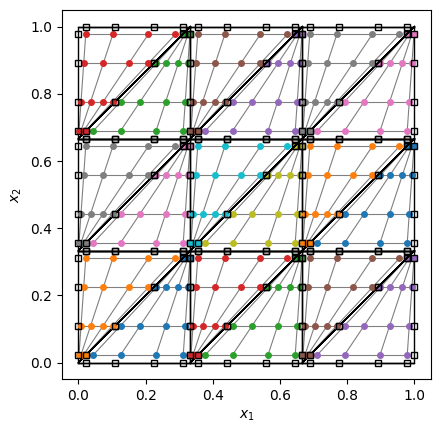

In [5]:
M = 3  # number of elements
p = 3  # degree of discretization
reference_approximation =ReferenceApproximation(
    DGSEM(p), CollapsedTri(), 
    quadrature_rule=(LGQuadrature(),LGQuadrature()),
    N_plot=ceil(Int,50/M), transform_type=SBPTransform());
spatial_discretization = SpatialDiscretization(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    ((0.0,L),(0.0,L)), (M,M)), reference_approximation);
results_path = save_project(conservation_law,
     spatial_discretization, initial_data, WeakConservationForm(), 
     (0.0, T), Lazy(), results_path, overwrite=true, clear=true)
visualize(spatial_discretization, plots_path, "mesh.pdf", grid_lines=true, plot_volume_nodes=true, plot_facet_nodes=true)

Run the `OrdinaryDiffEq` solver, taking `n_s` snapshots

In [6]:
reset_timer!()
n_s = 50
dt_scale=0.1
dt = dt_scale*(L/M)/(norm(a)*(2*p+1))
ode_problem = semidiscretize(load_project(results_path)...)
save_solution(ode_problem.u0, 0.0, results_path, 0)
sol = solve(ode_problem, Tsit5(), adaptive=false,
    dt=dt, save_everystep=false, krylov=:adaptive,
    callback=save_callback(results_path, ceil(Int, T/(dt*n_s))))
save_solution(last(sol.u), last(sol.t), results_path, "final")
print_timer()

 ──────────────────────────────────────────────────────────────────────────────
                                       Time                   Allocations      
                               ──────────────────────   ───────────────────────
       Tot / % measured:            14.7s / 24.2%           3.34GiB / 52.9%    

 Section               ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 rhs!                   1.83k    3.57s   100%  1.95ms   1.77GiB  100%   0.99MiB
   eval residual        33.0k    2.49s  69.7%  75.5μs   1.36GiB  76.7%  43.1KiB
     volume terms       33.0k    2.20s  61.5%  66.6μs   1.28GiB  72.3%  40.7KiB
     facet terms        33.0k    122ms  3.41%  3.69μs   47.2MiB  2.60%  1.46KiB
     mass matrix solve  33.0k   6.62ms  0.19%   201ns   6.54MiB  0.36%     208B
   extrapolate solu...  33.0k    605ms  16.9%  18.3μs    200MiB  11.0%  6.20KiB
   eval numerical flux  33.0k    179ms 

Visualize the solution

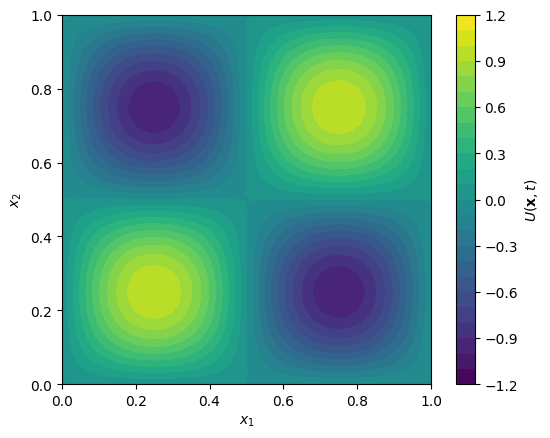

In [7]:
plotter = Plotter(spatial_discretization, plots_path)
visualize(initial_data, plotter, "exact.pdf", u_range=[-1.0,1.0], contours=25,
    label="U(\\mathbf{x},t)")

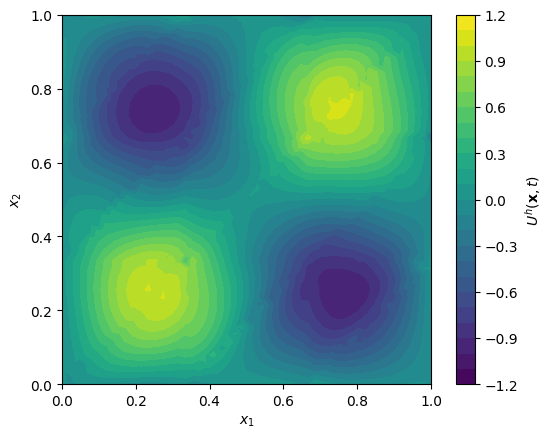

In [8]:
visualize(last(sol.u),plotter, "approx.pdf", contours=25, u_range=[-1.0,1.0],
    label="U^h(\\mathbf{x},t)")

Calculate the integral L<sup>2</sup> error norm and conservation/energy error

In [9]:
error_analysis = ErrorAnalysis(conservation_law, 
    spatial_discretization, 
    results_path)
println("L2 error: ", analyze(error_analysis, last(sol.u), initial_data))

conservation_analysis = PrimaryConservationAnalysis(conservation_law, 
    spatial_discretization, 
    results_path)
println("Conservation (initial/final/diff):\n", analyze(conservation_analysis)...)

energy_analysis = EnergyConservationAnalysis(conservation_law, 
    spatial_discretization, 
    results_path)
println("Energy (initial/final/diff):\n",analyze(energy_analysis)...)

L2 error: [0.029358986846414005]
Conservation (initial/final/diff):
[-3.469446951953614e-18][4.85722573273506e-17][5.204170427930421e-17]
Energy (initial/final/diff):
[0.2500000000000004][0.25000000039271053][3.9271014218300593e-10]
